In [111]:
import os
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
import matplotlib.pyplot as plt

# custom
from data_utilities import *

directory = 'D:\\racunalni_vid\dataset-verse19test\dataset-verse19test\derivatives\sub-verse054'

# Step 4: Load files for a single data sample
img_nib = nib.load(os.path.join(directory, 'sub-verse054_ct.nii.gz'))
msk_nib = nib.load(os.path.join(directory, 'sub-verse054_seg-vert_msk.nii.gz'))
ctd_list = load_centroids(os.path.join(directory, 'sub-verse054_seg-subreg_ctd.json'))

In [112]:
#check img zooms 
zooms = img_nib.header.get_zooms()
print('img zooms = {}'.format(zooms))

#check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_nib.affine))
print('img orientation code: {}'.format(axs_code))

#check centroids
print('Centroid List: {}'.format(ctd_list))

img zooms = (1.0, 1.0, 2.0)
img orientation code: ('P', 'I', 'R')
Centroid List: [('P', 'I', 'R'), [20, 95.1, 32.8, 26.4], [21, 84.8, 59.0, 26.1], [22, 75.1, 88.4, 26.7], [23, 68.6, 119.8, 27.9], [24, 74.6, 150.2, 28.0]]


In [113]:
# Resample and Reorient data
img_iso = resample_nib(img_nib, voxel_spacing=(1, 1, 1), order=3)
msk_iso = resample_nib(msk_nib, voxel_spacing=(1, 1, 1), order=0) # or resample based on img: resample_mask_to(msk_nib, img_iso)
ctd_iso = rescale_centroids(ctd_list, img_nib, (1,1,1))

img_iso = reorient_to(img_iso, axcodes_to=('I', 'P', 'L'))
msk_iso = reorient_to(msk_iso, axcodes_to=('I', 'P', 'L'))
ctd_iso = reorient_centroids_to(ctd_iso, img_iso)

#check img zooms 
zooms = img_iso.header.get_zooms()
print('img zooms = {}'.format(zooms))

#check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_iso.affine))
print('img orientation code: {}'.format(axs_code))

#check centroids
print('new centroids: {}'.format(ctd_iso))

[*] Image resampled to voxel size: (1, 1, 1)
[*] Image resampled to voxel size: (1, 1, 1)
[*] Rescaled centroid coordinates to spacing (x, y, z) = (1, 1, 1) mm
img zooms = (1.0, 1.0, 1.0)
img orientation code: ('I', 'P', 'L')
new centroids: [('I', 'P', 'L'), [20, 32.8, 95.1, 55.2], [21, 59.0, 84.8, 55.8], [22, 88.4, 75.1, 54.6], [23, 119.8, 68.6, 52.2], [24, 150.2, 74.6, 52.0]]


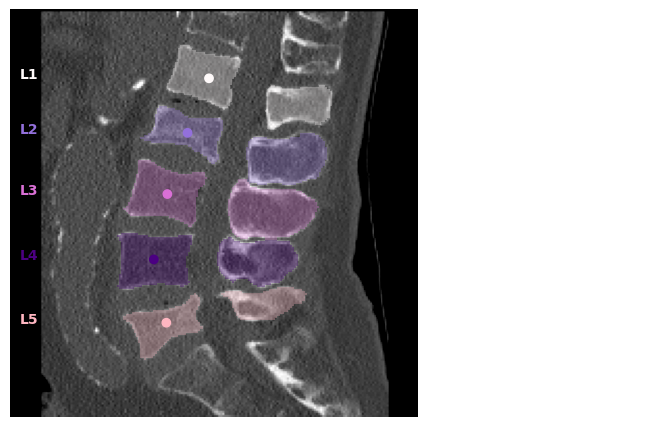

In [114]:
# get vocel data
im_np  = img_iso.get_fdata()
msk_np = msk_iso.get_fdata()

# get the mid-slice of the scan and mask in sagittal plane
im_np_sag = im_np[:,:,int(im_np.shape[2]/2)]
im_np_cor = im_np[:,int(im_np.shape[1]/2),:]

msk_np_sag = msk_np[:,:,int(msk_np.shape[2]/2)]
msk_np_sag[msk_np_sag==0] = np.nan

msk_np_cor = msk_np[:,int(msk_np.shape[1]/2),:]
msk_np_cor[msk_np_cor==0] = np.nan


# plot 
fig, axs = create_figure(96,im_np_sag, im_np_cor)

axs[0].imshow(im_np_sag, cmap=plt.cm.gray, norm=wdw_sbone)
axs[0].imshow(msk_np_sag, cmap=cm_itk, alpha=0.3, vmin=1, vmax=64)
plot_sag_centroids(axs[0], ctd_iso, zooms)


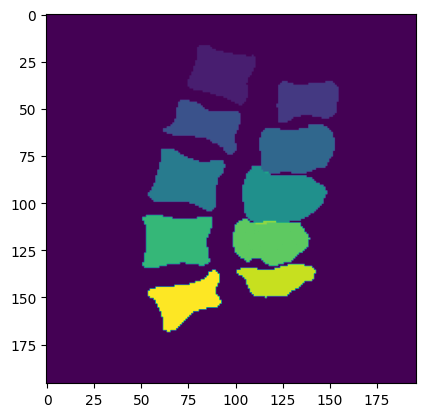

In [115]:
plt.imshow(msk_np_sag)
import skimage

labeled = skimage.measure.label(msk_np_sag)
plt.imshow(labeled)

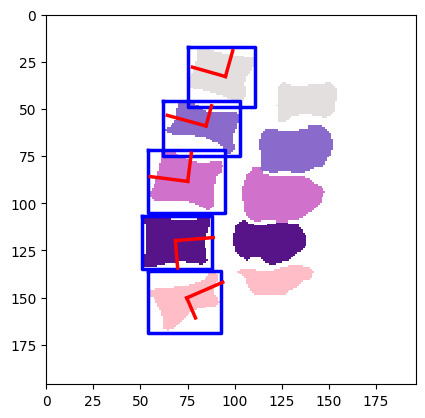

In [116]:
# Plot the original image
plt.imshow(msk_np_sag, cmap='grey')

# Set the axis limits to match the dimensions of the image
plt.xlim(0, msk_np_sag.shape[1])
plt.ylim(msk_np_sag.shape[0], 0)  # Invert y-axis to match image coordinates

# Measure region properties
regions = skimage.measure.regionprops(labeled)

# Get the areas of all regions
areas = [props.area for props in regions]

# Find the index of the largest region
largest_region_index = np.argmax(areas)

# Initialize an empty list to store matching bounding boxes
matching_bounding_boxes = []

# Loop through each region
for props in regions:
    # Exclude the largest region
    if props.label != largest_region_index + 1:
        # Get bounding box coordinates for the current region
        minr, minc, maxr, maxc = props.bbox
        
        # Initialize a flag to check if centroid is found in the current region
        centroid_found = False
        
        # Loop through centroids in ctd_iso and check if any falls within the current region
        for centroid in ctd_iso[1:]:
            centroid_x, centroid_y = centroid[2], centroid[1]
            if minc <= centroid_x <= maxc and minr <= centroid_y <= maxr:
                # Centroid is inside the region, set the flag and break the loop
                centroid_found = True
                break
        
        # If centroid is found, draw the bounding box and axes
        if centroid_found:
            # Draw the bounding box only for regions with centroids
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            plt.plot(bx, by, '-b', linewidth=2.5)
            
            # Get centroid and orientation
            y0, x0 = centroid[1], centroid[2]
            orientation = props.orientation
            
            # Calculate endpoints for major and minor axes
            x1 = x0 + np.cos(orientation) * 0.5 * props.minor_axis_length
            y1 = y0 - np.sin(orientation) * 0.5 * props.minor_axis_length
            x2 = x0 - np.sin(orientation) * 0.5 * props.major_axis_length
            y2 = y0 - np.cos(orientation) * 0.5 * props.major_axis_length
            
            # Draw major and minor axes
            plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)

            # Append the bounding box coordinates to the list
            matching_bounding_boxes.append((minr, minc, maxr, maxc))

# Convert the list of bounding boxes to a numpy array for easy manipulation
matching_bounding_boxes = np.array(matching_bounding_boxes)
plt.imshow(msk_np_sag, cmap=cm_itk, alpha=0.9, vmin=1, vmax=64)

plt.show()

15.820631077602428
15.298401067677418
7.286543030871172
175.46919499303903
156.48033453333986


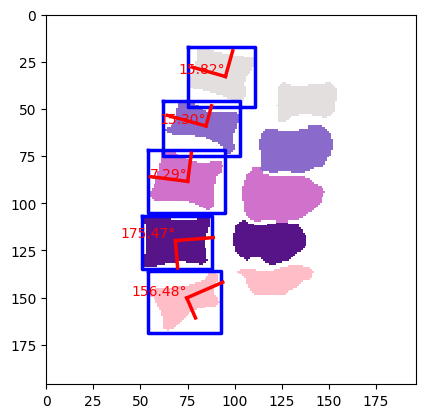

In [117]:
labeled = skimage.measure.label(msk_np_sag)
plt.imshow(msk_np_sag, cmap='gray')
plt.xlim(0, msk_np_sag.shape[1])
plt.ylim(msk_np_sag.shape[0], 0)
regions = skimage.measure.regionprops(labeled)
areas = [props.area for props in regions]
largest_region_index = np.argmax(areas)

matching_bounding_boxes = []
rotation_angles = []

for props in regions:
    if props.label != largest_region_index + 1:
        minr, minc, maxr, maxc = props.bbox
        centroid_found = False
        
        for centroid in ctd_iso[1:]:
            centroid_x, centroid_y = centroid[2], centroid[1]
            if minc <= centroid_x <= maxc and minr <= centroid_y <= maxr:
                centroid_found = True
                break
        
        if centroid_found:
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            plt.plot(bx, by, '-b', linewidth=2.5)
            
            y0, x0 = centroid[1], centroid[2]
            orientation = props.orientation
            
            x1 = x0 + np.cos(orientation) * 0.5 * props.minor_axis_length
            y1 = y0 - np.sin(orientation) * 0.5 * props.minor_axis_length
            x2 = x0 - np.sin(orientation) * 0.5 * props.major_axis_length
            y2 = y0 - np.cos(orientation) * 0.5 * props.major_axis_length
            
            plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
            
            # Calculate angle of rotation
            angle_rad = np.arctan2(y2 - y0, x2 - x0)
            angle_deg = np.degrees(angle_rad)
            
            # Ensure angle is between 0 and 180 degrees
            if angle_deg < 0:
                angle_deg += 180
            
            # Add text annotation to the plot
            plt.text(x0, y0, f"{angle_deg:.2f}°", color='red', ha='right', va='bottom')
            print(angle_deg)
            
            matching_bounding_boxes.append((minr, minc, maxr, maxc))
            rotation_angles.append(angle_deg)

matching_bounding_boxes = np.array(matching_bounding_boxes)
plt.imshow(msk_np_sag, cmap=cm_itk, alpha=0.9, vmin=1, vmax=64)

plt.show()

# # Calculate Cobb angle
# rotation_angles = np.array(rotation_angles)
# largest_angles_idx = rotation_angles.argsort()[-2:]
# largest_angles = rotation_angles[largest_angles_idx]
# cobb_angle = np.abs(np.diff(largest_angles))[0]

# print("Cobb Angle:", cobb_angle)

Cobb Angle (degrees): 37.61094966983909


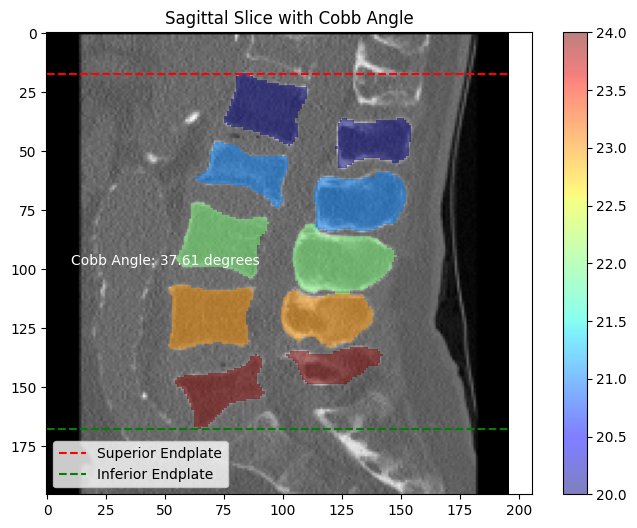

In [118]:
def calculate_cobb_angle(mask_data):
    # Find the indices of the superior and inferior endplates
    endplate_indices = np.where(~np.isnan(mask_data))

    # Assume we found the superior and inferior indices correctly
    sup_endplate_idx = np.min(endplate_indices)
    inf_endplate_idx = np.max(endplate_indices)

    # Calculate the Cobb angle using the indices
    cobb_angle = np.arctan((inf_endplate_idx - sup_endplate_idx) / mask_data.shape[1]) * 180 / np.pi

    return cobb_angle

# Calculate Cobb angle for the mid-slice in sagittal plane
cobb_angle = calculate_cobb_angle(msk_np_sag)

print("Cobb Angle (degrees):", cobb_angle)


def calculate_cobb_angle(mask_data):
    # Find the indices of the superior and inferior endplates
    endplate_indices = np.where(~np.isnan(mask_data))

    # Assume we found the superior and inferior indices correctly
    sup_endplate_idx = np.min(endplate_indices)
    inf_endplate_idx = np.max(endplate_indices)

    # Calculate the Cobb angle using the indices
    cobb_angle = np.arctan((inf_endplate_idx - sup_endplate_idx) / mask_data.shape[1]) * 180 / np.pi

    return cobb_angle, sup_endplate_idx, inf_endplate_idx

# Calculate Cobb angle for the mid-slice in sagittal plane
cobb_angle, sup_idx, inf_idx = calculate_cobb_angle(msk_np_sag)

# Plot the mid-slice image
plt.figure(figsize=(8, 6))
plt.imshow(im_np_sag, cmap='gray')
plt.title('Sagittal Slice with Cobb Angle')

# Plot the mask overlay
plt.imshow(msk_np_sag, cmap='jet', alpha=0.5)

# Plot lines for the Cobb angle
plt.plot([0, msk_np_sag.shape[1]], [sup_idx, sup_idx], 'r--', label='Superior Endplate')
plt.plot([0, msk_np_sag.shape[1]], [inf_idx, inf_idx], 'g--', label='Inferior Endplate')

# Add Cobb angle text
plt.text(10, msk_np_sag.shape[0] // 2, f'Cobb Angle: {cobb_angle:.2f} degrees', color='white')

plt.colorbar()
plt.legend()
plt.show()